# Import

In [1]:
!nvidia-smi

import warnings
warnings.filterwarnings('ignore')

import os
import sys
import cv2
import time
import random
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy import interp
import albumentations as A
from itertools import cycle
from sklearn import metrics
from IPython import display
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix as sk_cm
%matplotlib inline

Sat Aug 24 23:31:45 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Variables and Methods

In [2]:
class_to_num = {
    'Myself': 0,
    'Sister': 1,
    'Mother': 2,
    'Father':3
}

num_to_class = ['Myself', 'Sister', 'Mother', 'Father']
class_colors = ['C1', 'C2', 'C3', 'C0']
NUM_CLASSES = 4

In [3]:
from myutilitymethods import MyMethods
from mycnn import MyCNN

Using TensorFlow backend.


In [4]:
mm = MyMethods(NUM_CLASSES, num_to_class, class_to_num)

# Methods

In [5]:
def read_csv(filepath, aug_factor=10, print_progress=False, img_size=28):
    '''Takes in .csv and returns the compressed images's pixels in RGB format as Numpy array'''
    img = pd.read_csv(filepath, header=None).values
    return img.reshape(img.shape[0], img_size, img_size, 3)

In [6]:
def prepare_x(images_tuple, hd=False):
    '''Prepare x set'''  
    x = np.concatenate(images_tuple, axis=0)
    x_hd = []
    if hd:
        x_hd = np.concatenate(images_tuple, axis=0)
    return x, x_hd

In [7]:
def prepare_y(images_tuple):
    '''Prepare y set'''
    y_eklavya = [class_to_num['Myself']] * len(images_tuple[0])
    y_aranya = [class_to_num['Sister']] * len(images_tuple[1])
    y_mom = [class_to_num['Mother']] * len(images_tuple[2])
    y_dad = [class_to_num['Father']] * len(images_tuple[3])
    # Combine
    y = y_eklavya + y_aranya + y_mom + y_dad
    return np.array(y)

In [8]:
def plot_all_confusion_matrices(y_true, y_pred, y_true_val, y_pred_val, y_true_test, y_pred_test, 
                                classes, save_title, normalize=False, title=None, cmap='GnBu', dpi=150):
    '''Plot train, validation, and test confusion matrices'''
    if not title:
        if normalize:
            title = 'Normalized Confusion Matrices'
        else:
            title = 'Non-Normalized Confusion Matrices'
    # Compute confusion matrix
    cm_train = sk_cm(y_true, y_pred)
    cm_val = sk_cm(y_true_val, y_pred_val)
    cm_test = sk_cm(y_true_test, y_pred_test)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize: 
        cm_train = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
        cm_val   = cm_val.astype('float')   / cm_val.sum(axis=1)  [:, np.newaxis]
        cm_test  = cm_test.astype('float')  / cm_test.sum(axis=1) [:, np.newaxis]
    # Lists  
    cms = [cm_train, cm_val, cm_test]
    titles = ['Train', 'Validation', 'Test']
    fig, axes = plt.subplots(nrows=1, ncols=3, dpi=dpi, figsize=(15, 8))
    # Loop
    for i, ax in enumerate(axes):
        im = ax.imshow(cms[i], interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
        # Label
        ax.set(xticks=np.arange(cms[i].shape[1]),
               yticks=np.arange(cms[i].shape[0]),
               xticklabels=classes, 
               yticklabels=classes,
               title=titles[i]
               )
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_yticklabels(), rotation=90, ha="right", rotation_mode="anchor")
    # Loop
    for c, cm in enumerate(cms):
        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        # Loop
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                axes[c].text(j, i, format(cm[i, j], fmt), 
                             ha="center", va="center", 
                             color="white" if cm[i, j] > thresh else "black")
    # For only one ax
    axes[0].set(ylabel='True label',)
    axes[1].set(xlabel='Predicted label')
    # Adjust
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.83, 0.315, 0.025, 0.375]) # [left, bottom, width, height]
    fig.colorbar(im, cax=cbar_ax)
    
    # Save
    fig.savefig(f'{save_title}.pdf', bbox_inches='tight', format='pdf', dpi=200)
    
    # Plot
    plt.show()

In [9]:
def process_data(raw_data_list, augs):
    processed_data = []
    batch = []
    for i, raw_data in enumerate(raw_data_list):
        for img in raw_data:
            img = mm.convertToRGB(img.astype('uint8'))
            img = mm.equalise_image(img, eq_type='HSV')
            imgs = mm.augment_images(img, augs[i])
            imgs = mm.standardise_images(imgs)
            batch.append(imgs)
        processed_data.append(np.concatenate(batch))
        batch = []
    return processed_data

# Import Data

In [10]:
# Read in raw data
myself_raw = read_csv('../input/familyfaces/Myself.csv')
sister_raw = read_csv('../input/familyfaces/Sister.csv')
mother_raw = read_csv('../input/familyfaces/Mother.csv')
father_raw = read_csv('../input/familyfaces/Father.csv')

In [11]:
# Process
raw_data_list = [myself_raw, sister_raw, mother_raw, father_raw]
augs = [5,5,10,15]
processed_data = process_data(raw_data_list, augs)

# Prepare datasets
images_tuple = tuple(processed_data)
raw_x, _ = prepare_x(images_tuple)
raw_y = prepare_y(images_tuple)
x, y = shuffle(raw_x, raw_y, random_state=0)
x_train, y_train, x_test, y_test = mm.split_train_test(x, y, split=0.95)

# Data Exploration

In [12]:
print('Eklavya :', processed_data[0].shape[0]/(augs[0]+1), 'x', augs[0], '=', processed_data[0].shape[0])
print('Aranya  :', processed_data[1].shape[0]/(augs[1]+1), 'x', augs[1], '=', processed_data[1].shape[0])
print('Mom     :', processed_data[2].shape[0]/(augs[2]+1), 'x', augs[2], '=', processed_data[2].shape[0])
print('Dad     :', processed_data[3].shape[0]/(augs[3]+1), 'x', augs[3], '=', processed_data[3].shape[0])
print('Total   :\t     ', np.sum([np.sum(a.shape[0]) for a in processed_data]))

Eklavya : 1078.0 x 5 = 6468
Aranya  : 1117.0 x 5 = 6702
Mom     : 564.0 x 10 = 6204
Dad     : 153.0 x 15 = 2448
Total   :	      21822


In [13]:
sets = ((x,y), (x_train, y_train), (x_test, y_test))

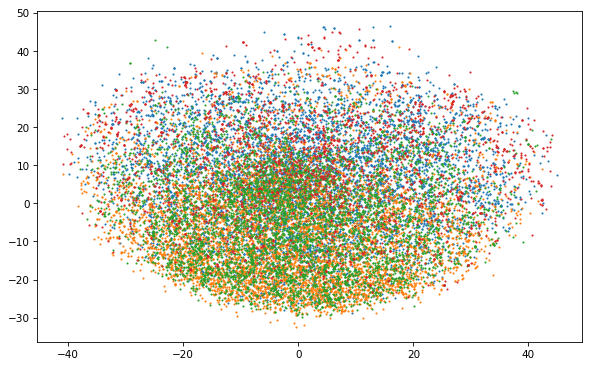

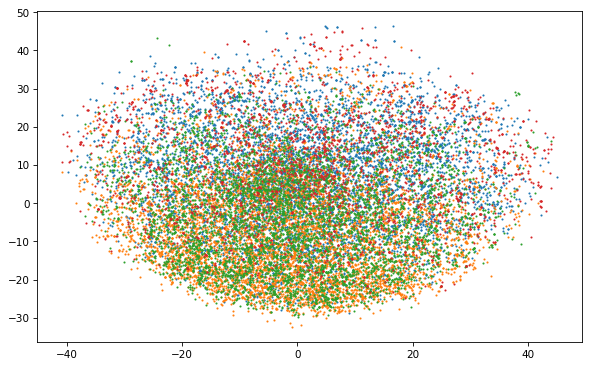

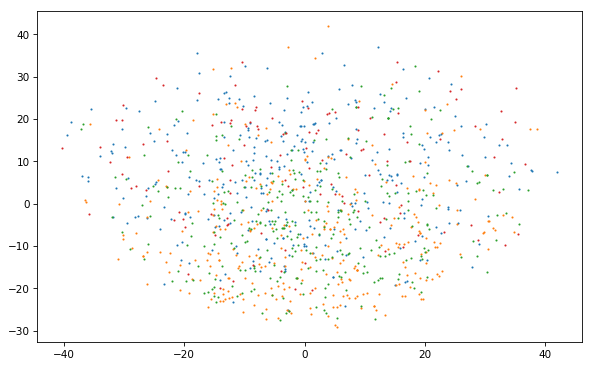

In [14]:
for my_set in sets:
    mm.plot_pca(my_set[0], my_set[1], dpi=75)

In [15]:
nbs = []
for img in images_tuple:
    nbs.append(len(img))

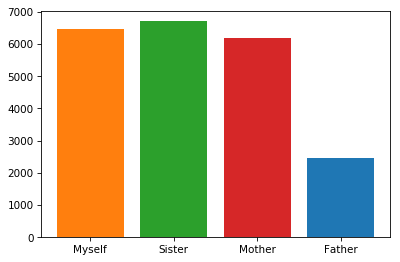

In [16]:
plt.figure(dpi=75)
plt.bar(num_to_class, nbs, color=class_colors)
plt.savefig('DataExploration1.pdf', bbox_inches='tight', format='pdf', dpi=200)
plt.show()

In [17]:
og_nbs = [nbs[i]/(augs[i]+1) for i in range(len(augs))]

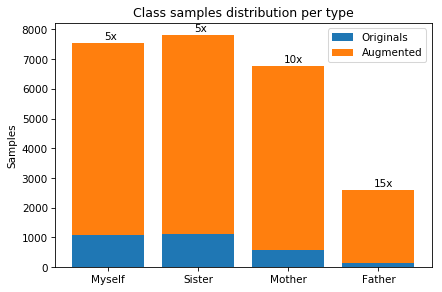

In [18]:
plt.figure(dpi=75)

p1 = plt.bar(num_to_class, og_nbs)
p2 = plt.bar(num_to_class, nbs, bottom=og_nbs)

plt.ylabel('Samples')
plt.title('Class samples distribution per type')
plt.legend((p1, p2), ('Originals', 'Augmented'))
#plt.grid(True, alpha=0.3, which='major', linestyle='--')

xlocs, xlabs = plt.xticks()

for i, v in enumerate(augs):
    plt.text(xlocs[i]-0.05, v+og_nbs[i]+nbs[i]+100, str(v)+'x')

plt.tight_layout()
plt.savefig('DataExploration2.pdf', bbox_inches='tight', format='pdf', dpi=200)
plt.show()

# Assert

In [19]:
# One-hot encode
y_train = mm.one_hot_encode(y_train)
y_test = mm.one_hot_encode(y_test)

In [20]:
# Assert shapes
assert(y_train.shape[1]==NUM_CLASSES)
assert(y_test.shape[1]==NUM_CLASSES)

In [21]:
# Assert std devs
assert(np.round(x_train[0].std(), 3) == 1)
assert(np.round(x_test[0].std(),  3) == 1)

In [22]:
# Assert means
assert(np.round(x_train[0].mean(), 3) == 0)
assert(np.round(x_test[0].mean(),  3) == 0)

# Model

In [23]:
try:
  sess
except NameError:
    pass
else:
    sess.close()
tf.reset_default_graph()

# Setup model
model = MyCNN(x_train[:20700], 
              y_train[:20700], 
              x_test,
              y_test,
              output_dir='./Reco_w_kCV/',
              num_to_class=num_to_class, 
              class_to_num=class_to_num,
              lr=1e-5,
              nb_epochs=50, 
              batch_size_train=30,
              seed=0,
              final_activation='softmax')

# Initialise model
model.create_model()
model.compute_loss()
model.optimizer()
model.set_up_saver()
tf.initialize_all_variables().run(session=model.sess)

# Make path if necessary
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)

## Model with k-cross validation

In [24]:
%%time
# Train model
model.train(verbose=False, cross_k_fold_validation=True)

CPU times: user 2min 13s, sys: 1min, total: 3min 13s
Wall time: 2min 34s


In [25]:
# Test model
model.test()

Test accuracy achieved: 0.945


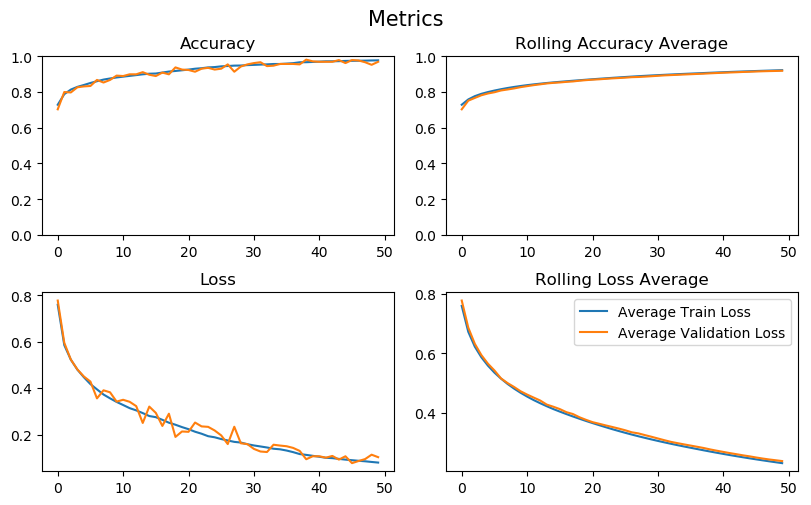

In [26]:
# Plot variables over training and validation
mm.plot_metrics(model.accuracy_list, 
                model.losses_list, 
                model.val_accuracy_list, 
                model.val_losses_list,
                save_title='w_kCV_metrics')

In [27]:
# Get train metrics report
report = classification_report(np.argmax(model.y_train, axis=1), 
                               model.preds_list, 
                               target_names=class_to_num, 
                               output_dict=True)
my_df = pd.DataFrame.from_dict(report).T.round(2)
my_df

,f1-score,precision,recall,support
Myself,0.98,0.99,0.97,6128.00
Sister,0.97,0.96,0.99,6372.00
Mother,0.97,0.97,0.98,5878.00
Father,0.98,0.99,0.97,2322.00
accuracy,0.98,0.98,0.98,0.98
macro avg,0.98,0.98,0.97,20700.00
weighted avg,0.98,0.98,0.98,20700.00


In [28]:
print(my_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  f1-score &  precision &  recall &   support \\
\midrule
Myself       &      0.98 &       0.99 &    0.97 &   6128.00 \\
Sister       &      0.97 &       0.96 &    0.99 &   6372.00 \\
Mother       &      0.97 &       0.97 &    0.98 &   5878.00 \\
Father       &      0.98 &       0.99 &    0.97 &   2322.00 \\
accuracy     &      0.98 &       0.98 &    0.98 &      0.98 \\
macro avg    &      0.98 &       0.98 &    0.97 &  20700.00 \\
weighted avg &      0.98 &       0.98 &    0.98 &  20700.00 \\
\bottomrule
\end{tabular}



In [29]:
# Get validation metrics report
report = classification_report(np.argmax(model.y_val, axis=1), 
                               model.preds_list_val, 
                               target_names=class_to_num, 
                               output_dict=True)
my_df = pd.DataFrame.from_dict(report).T.round(2)
my_df

,f1-score,precision,recall,support
Myself,0.97,0.99,0.95,138.00
Sister,0.96,0.93,0.99,111.00
Mother,0.97,0.97,0.97,120.00
Father,0.99,1.00,0.98,45.00
accuracy,0.97,0.97,0.97,0.97
macro avg,0.97,0.97,0.97,414.00
weighted avg,0.97,0.97,0.97,414.00


In [30]:
print(my_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  f1-score &  precision &  recall &  support \\
\midrule
Myself       &      0.97 &       0.99 &    0.95 &   138.00 \\
Sister       &      0.96 &       0.93 &    0.99 &   111.00 \\
Mother       &      0.97 &       0.97 &    0.97 &   120.00 \\
Father       &      0.99 &       1.00 &    0.98 &    45.00 \\
accuracy     &      0.97 &       0.97 &    0.97 &     0.97 \\
macro avg    &      0.97 &       0.97 &    0.97 &   414.00 \\
weighted avg &      0.97 &       0.97 &    0.97 &   414.00 \\
\bottomrule
\end{tabular}



In [31]:
# Get test metrics report
report = classification_report(np.argmax(model.y_test, axis=1), 
                               model.preds_list_test, 
                               target_names=class_to_num, 
                               output_dict=True)
my_df = pd.DataFrame.from_dict(report).T.round(2)
my_df

,f1-score,precision,recall,support
Myself,0.97,0.96,0.97,334.00
Sister,0.93,0.92,0.94,322.00
Mother,0.94,0.94,0.94,314.00
Father,0.93,0.96,0.90,122.00
accuracy,0.95,0.95,0.95,0.95
macro avg,0.94,0.95,0.94,1092.00
weighted avg,0.95,0.95,0.95,1092.00


In [32]:
print(my_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  f1-score &  precision &  recall &  support \\
\midrule
Myself       &      0.97 &       0.96 &    0.97 &   334.00 \\
Sister       &      0.93 &       0.92 &    0.94 &   322.00 \\
Mother       &      0.94 &       0.94 &    0.94 &   314.00 \\
Father       &      0.93 &       0.96 &    0.90 &   122.00 \\
accuracy     &      0.95 &       0.95 &    0.95 &     0.95 \\
macro avg    &      0.94 &       0.95 &    0.94 &  1092.00 \\
weighted avg &      0.95 &       0.95 &    0.95 &  1092.00 \\
\bottomrule
\end{tabular}



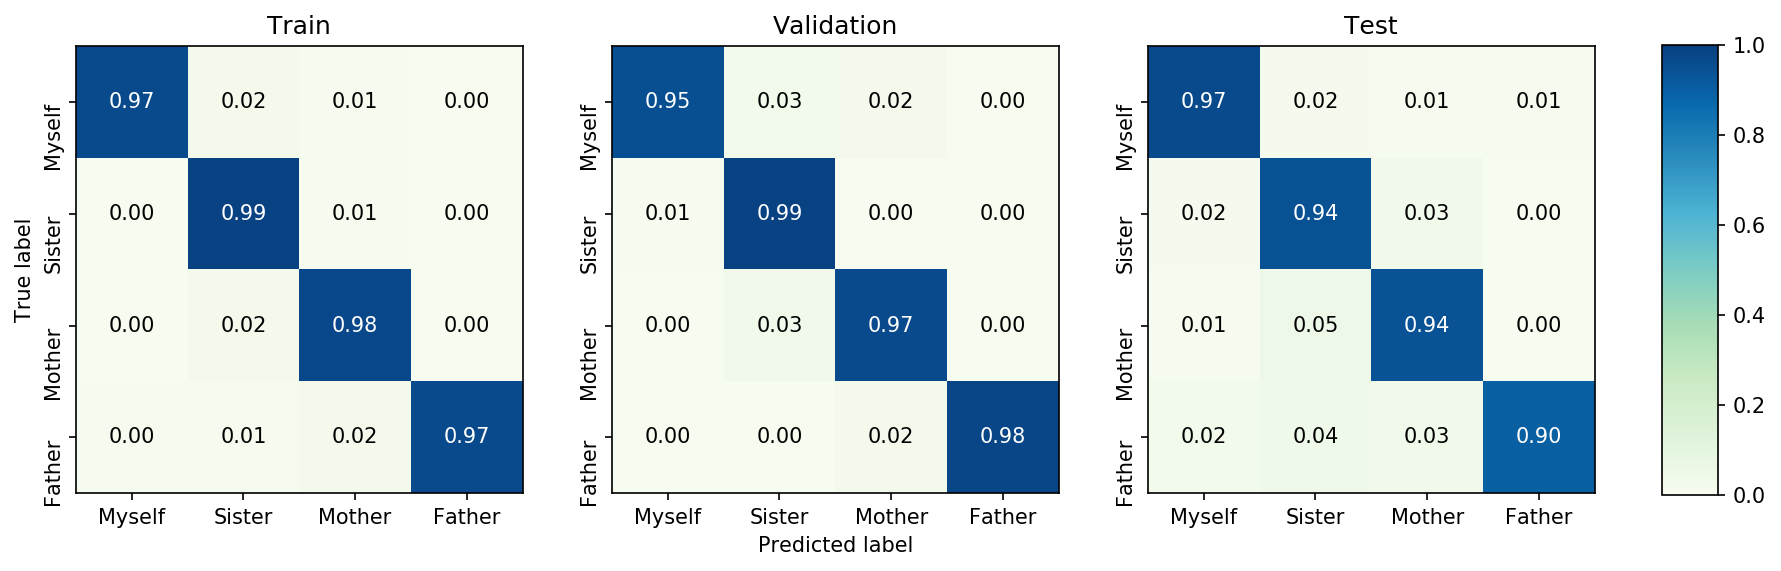

In [33]:
plot_all_confusion_matrices(np.argmax(model.y_train, axis=1), model.preds_list, 
                            np.argmax(model.y_val, axis=1), model.preds_list_val, 
                            np.argmax(model.y_test, axis=1), model.preds_list_test, 
                            np.array(num_to_class), 'CM_w_kCV',normalize=True)

In [34]:
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(np.argmax(y_train[:20700], axis=1), model.probs_list[:,1]     , pos_label=1)
fpr_val,   tpr_val,   thresholds_val   = metrics.roc_curve(np.argmax(model.y_val, axis=1)    , model.probs_list_val[:,1] , pos_label=1)
fpr_test,  tpr_test,  thresholds_test  = metrics.roc_curve(np.argmax(y_test, axis=1)         , model.probs_list_test[:,1], pos_label=1)

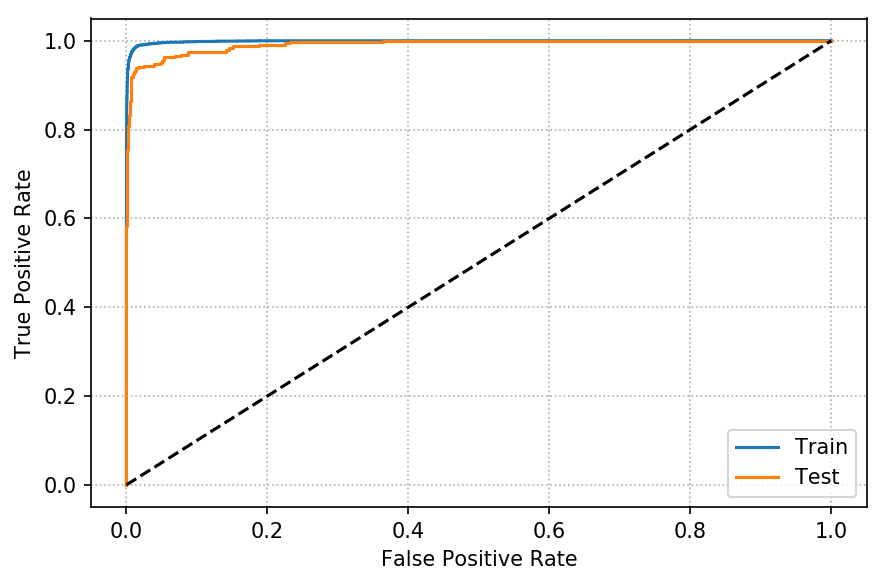

In [35]:
plt.figure(dpi=150)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr_train, tpr_train, label='Train')
plt.plot(fpr_test, tpr_test, label='Test')
plt.plot([0,1],[0,1], '--', color='k')
plt.grid(True, linestyle='dotted', alpha=1)
plt.legend()
plt.tight_layout()
plt.savefig('ROC1.pdf', bbox_inches='tight', format='pdf', dpi=200)
plt.show()

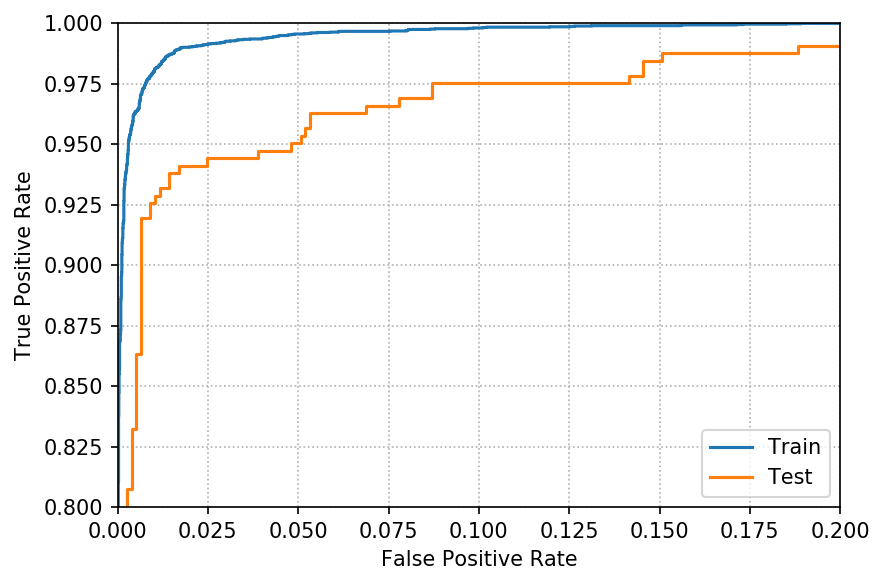

In [36]:
plt.figure(dpi=150)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr_train, tpr_train, label='Train')
plt.plot([0,1],[0,1], '--', color='k')
plt.plot(fpr_test, tpr_test, label='Test')
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.grid(True, linestyle='dotted', alpha=1)
plt.legend(loc=4)
plt.tight_layout()
plt.savefig('ROC2.pdf', bbox_inches='tight', format='pdf', dpi=200)
plt.show()

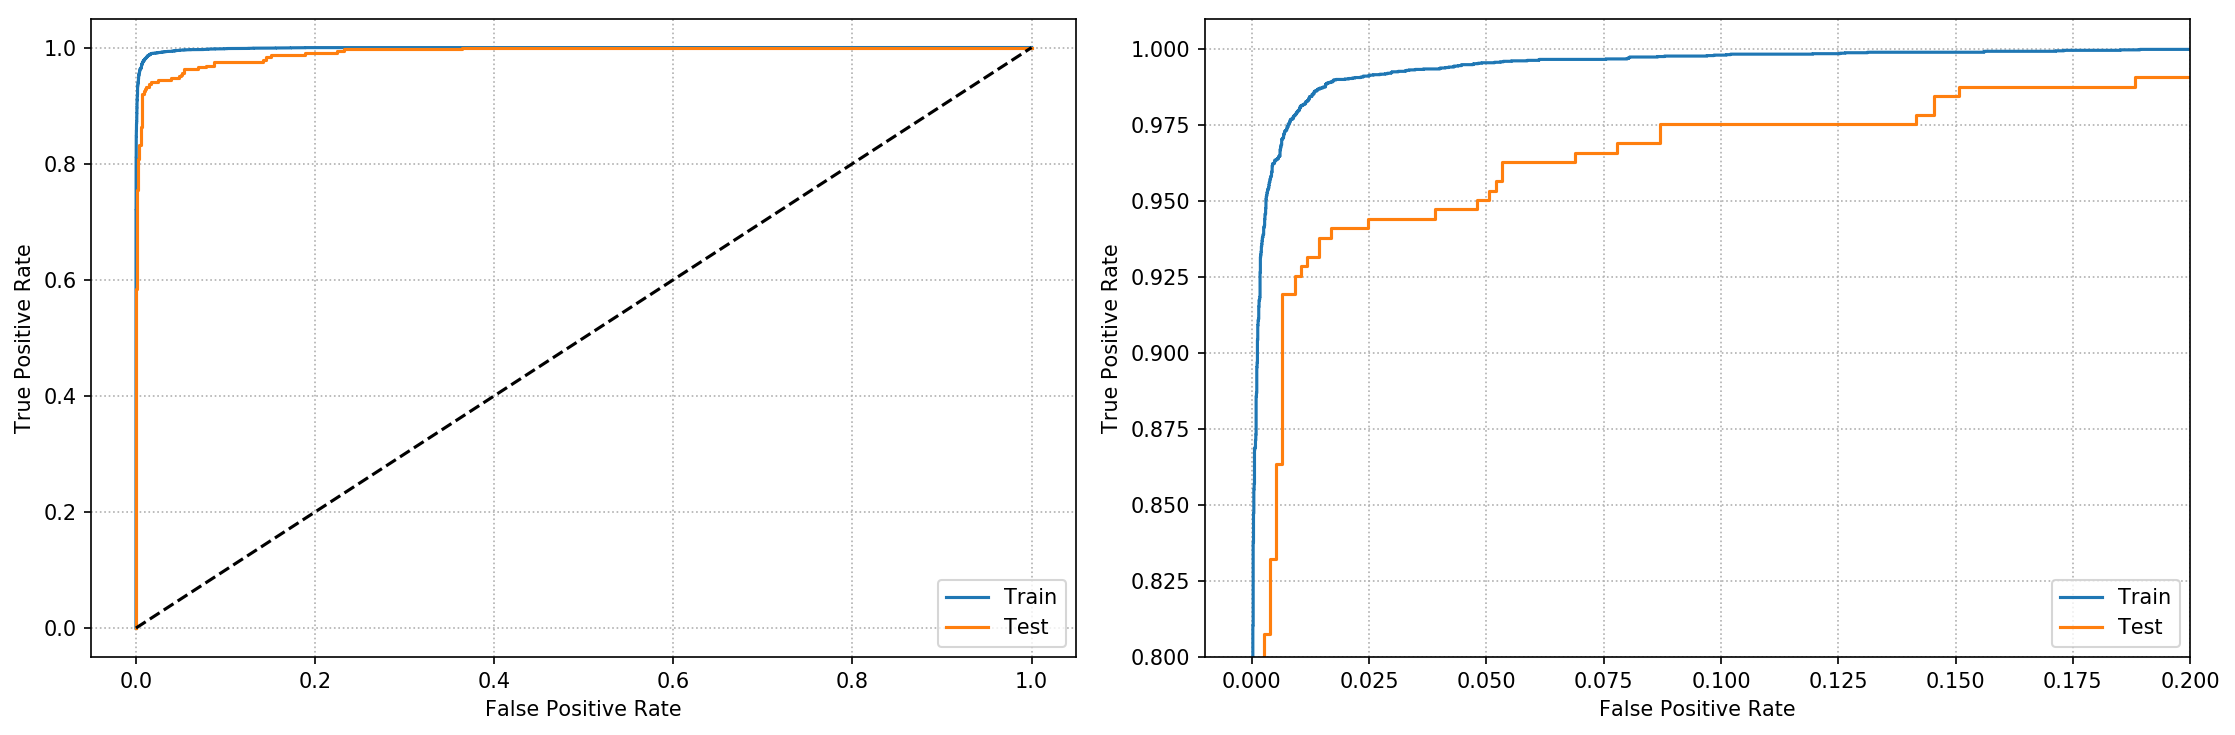

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(15,5))
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')

axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')

axes[0].plot(fpr_train, tpr_train, label='Train')
axes[0].plot(fpr_test, tpr_test, label='Test')
axes[0].plot([0,1],[0,1], '--', color='k')

axes[1].plot(fpr_train, tpr_train, label='Train')
axes[1].plot(fpr_test, tpr_test, label='Test')
axes[1].plot([0,1],[0,1], '--', color='k')

axes[1].set_xlim(-0.01, 0.2)
axes[1].set_ylim(0.8, 1.01)

axes[0].grid(True, linestyle='dotted', alpha=1)
axes[1].grid(True, linestyle='dotted', alpha=1)

axes[0].legend(loc=4)
axes[1].legend(loc=4)

# Save
fig.tight_layout() 
fig.savefig('TrainTestROC.pdf', bbox_inches='tight', format='pdf', dpi=200)

plt.show()

In [38]:
#train_auc = '('+str(np.round(metrics.roc_auc_score(np.argmax(y_train[:20700], axis=1), model.preds_list), 3)*100)+'%)'
#test_auc = '('+str(np.round(metrics.roc_auc_score(np.argmax(y_test, axis=1), model.preds_list_test), 3)*100)+'%)'

## ROC AUC

In [39]:
def make_fpr_tpr_auc_dicts(y, probs_list):
    '''Compute and return the ROC curve and ROC area for each class in dictionaries'''
    # Dicts
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    roc_auc = dict()
    
    # For test
    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], thresholds[i] = metrics.roc_curve(y[:, i], probs_list[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y.ravel(), probs_list.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(NUM_CLASSES):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
    # Finally average it and compute AUC
    mean_tpr /= NUM_CLASSES
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
    
    return fpr, tpr, thresholds, roc_auc

In [40]:
def plot_roc_auc_curves(fpr, tpr, roc_auc, save_title, xlim=(-0.0025, 0.03), ylim=(0.99, 1.001)):
    '''Plot ROC AUC Curves'''
    fig, axes = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(10,5))
    
    lw = 2
    axes[0].set_xlabel('False Positive Rate')
    axes[1].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    
    for i in range(NUM_CLASSES):
        axes[0].plot(fpr[i], tpr[i], color=class_colors[i], label='{0} ROC Curve ({1:0.2f})' ''.format(num_to_class[i], roc_auc[i]))
        axes[1].plot(fpr[i], tpr[i], color=class_colors[i], lw=lw, label='{0} ROC Curve ({1:0.2f})' ''.format(num_to_class[i], roc_auc[i]))
    
    axes[0].plot(fpr['micro'], tpr['micro'], label='Micro avg (%0.2f)' % roc_auc['micro'], linestyle=':', color='deeppink')
    axes[0].plot(fpr['macro'], tpr['macro'], label='Macro avg (%0.2f)' % roc_auc['macro'], linestyle=':', color='navy')
    axes[0].plot([0, 1], [0, 1], color='k', linestyle='--', lw=0.5)
    axes[0].scatter(0,1, label='Ideal', s=2)
    
    axes[1].plot(fpr['micro'], tpr['micro'], lw=lw, label='Micro avg (%0.2f)' % roc_auc['micro'], linestyle=':', color='deeppink')
    axes[1].plot(fpr['macro'], tpr['macro'], lw=lw, label='Macro avg (%0.2f)' % roc_auc['macro'], linestyle=':', color='navy')
    axes[1].plot([0, 1], [0, 1], color='k', linestyle='--', lw=0.5)
    axes[1].scatter(0,1, label='Ideal', s=50)
    
    axes[1].set_xlim(xlim)
    axes[1].set_ylim(ylim)
    
    axes[0].grid(True, linestyle='dotted', alpha=1)
    axes[1].grid(True, linestyle='dotted', alpha=1)
    
    axes[0].legend(loc=4)
    axes[1].legend(loc=4)
    
    plt.legend(loc="lower right")
    fig.tight_layout()  
    fig.savefig(f'{save_title}.pdf', bbox_inches='tight', format='pdf', dpi=200)
    plt.show()

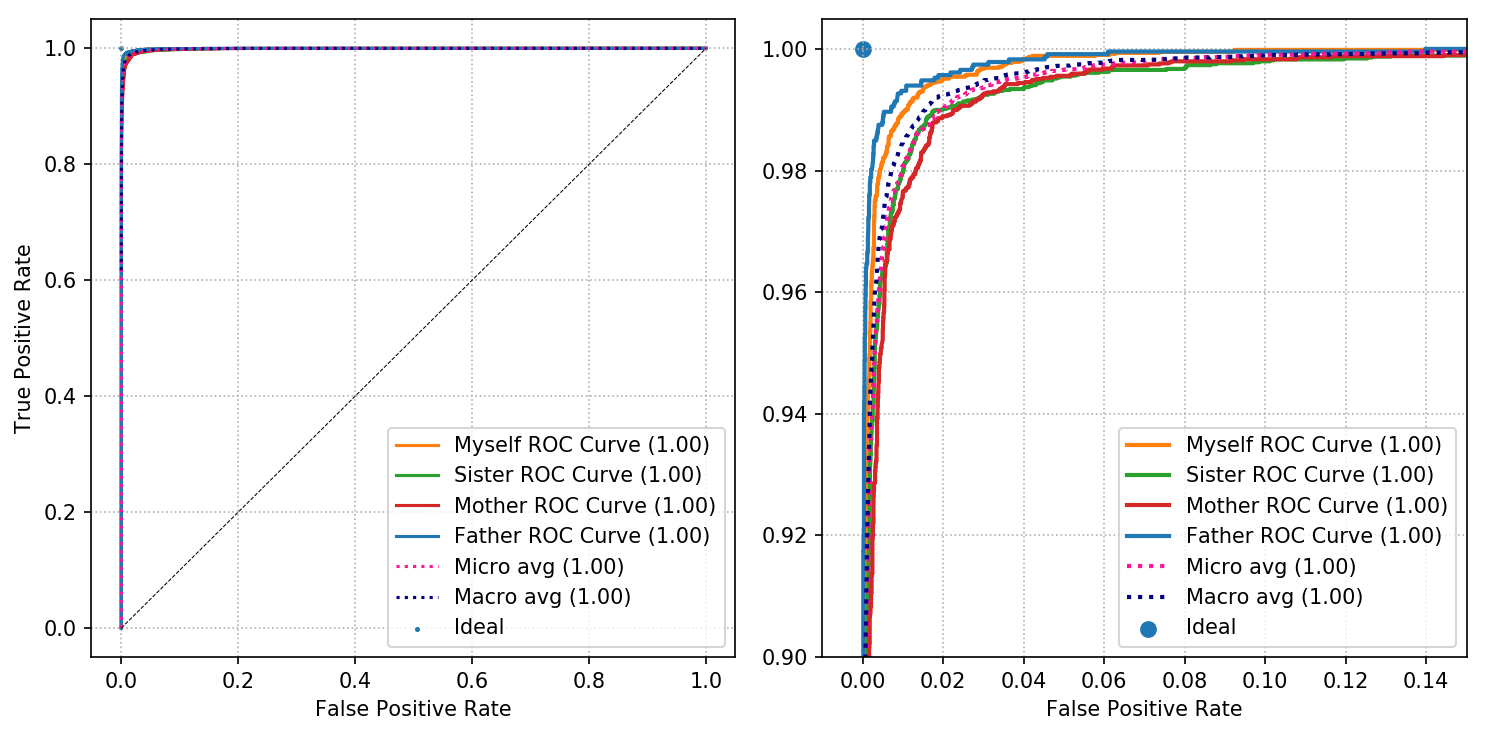

In [41]:
# Train ROC/AUC
fpr, tpr, thresholds, roc_auc = make_fpr_tpr_auc_dicts(model.y_train, model.probs_list)
plot_roc_auc_curves(fpr, tpr, roc_auc, 'TrainROCwkCV', xlim=(-0.01, 0.15), ylim=(0.90, 1.005))

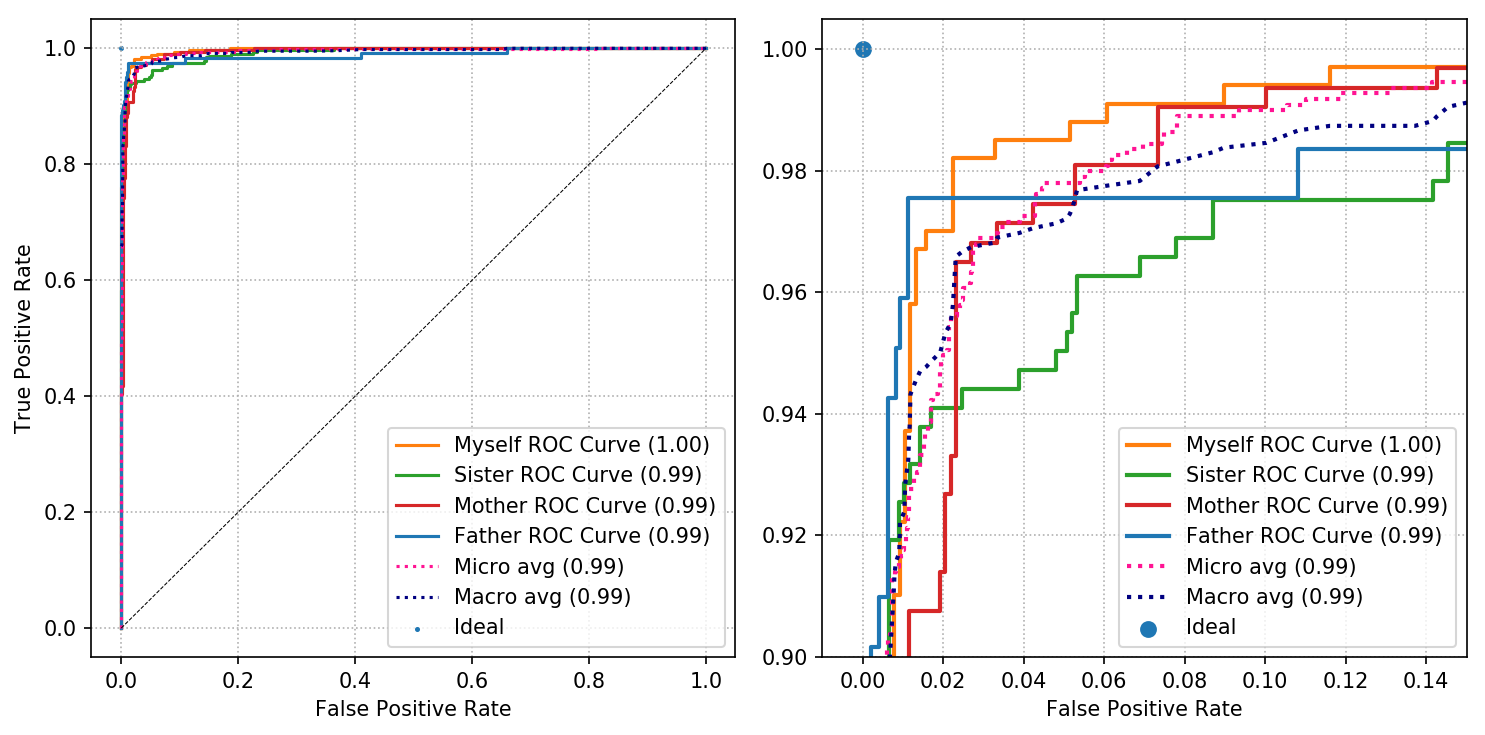

In [42]:
# Test ROC/AUC
fpr, tpr, thresholds, roc_auc = make_fpr_tpr_auc_dicts(model.y_test, model.probs_list_test)
plot_roc_auc_curves(fpr, tpr, roc_auc, 'TestROCwkCV', xlim=(-0.01, 0.15), ylim=(0.90, 1.005))

In [43]:
def get_optimal_threshold(fpr, tpr, threshold):
    '''Returns optimal thresholds given the fpr, tpr, and thresholds list.'''
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]['threshold'].values
    return np.asscalar(roc_t)

In [44]:
def get_val(fpr, tpr, thresholds):
    optimal_idx = np.argmin(np.abs(tpr - fpr))
    return thresholds[optimal_idx]

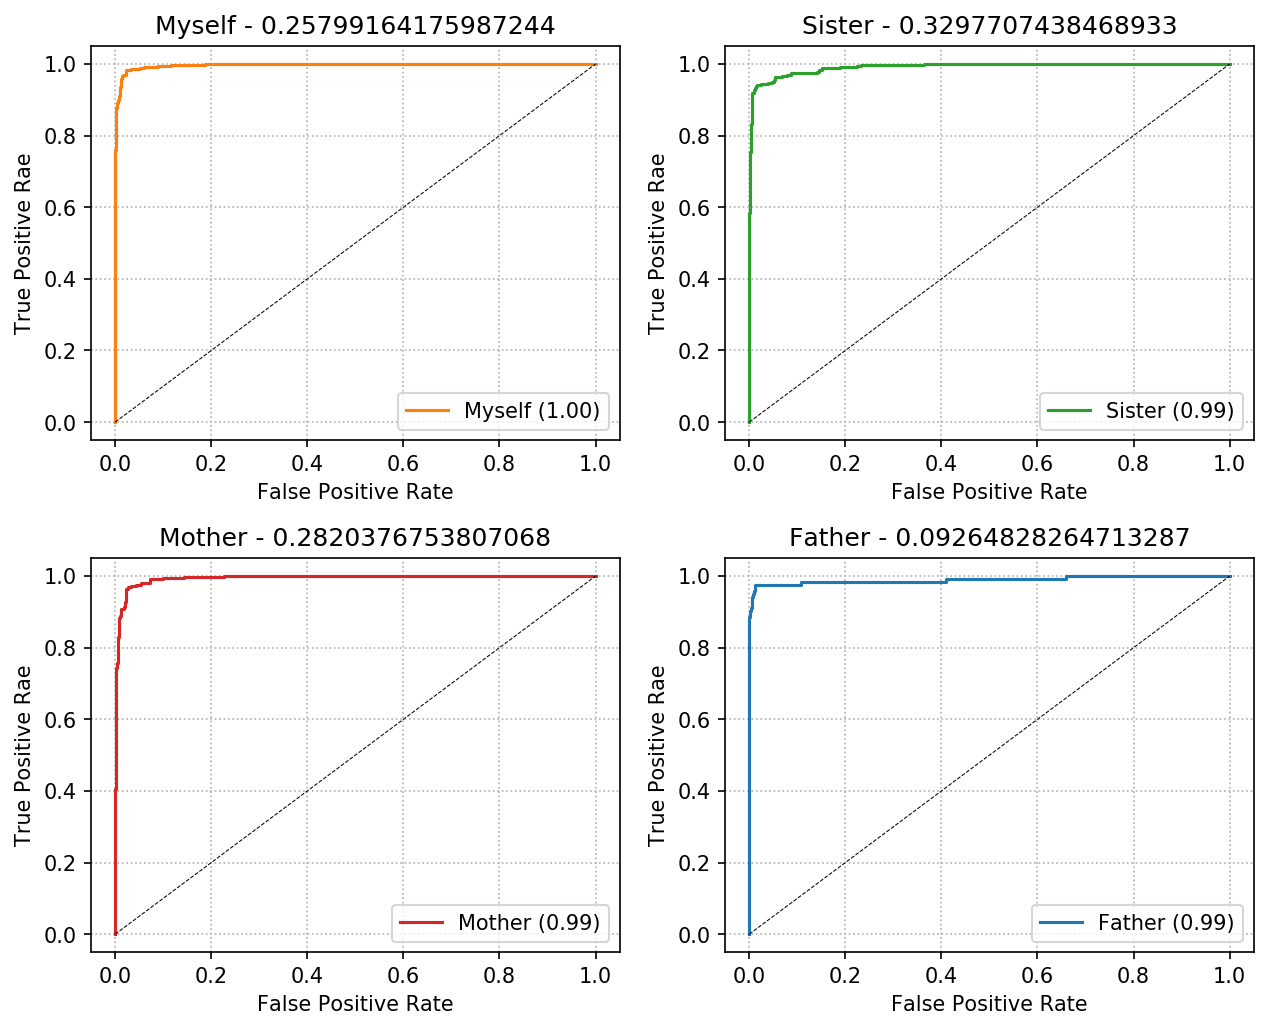

In [45]:
optimal_thresholds = []
plt.figure(figsize=(10,8), dpi=150)
plt.subplots_adjust(hspace = 0.3)
for i in range(NUM_CLASSES):
    cutoff = get_optimal_threshold(fpr[i], tpr[i], thresholds[i])
    optimal_thresholds += [cutoff]
    plt.subplot(2,2,i+1)
    plt.plot(fpr[i], tpr[i], color=class_colors[i], label=num_to_class[i] + ' (%0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='k', linestyle='--', lw=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rae')
    plt.title(f'{num_to_class[i]} - {cutoff}')
    plt.grid(True, linestyle='dotted', alpha=1)
    plt.legend(loc=4)

fig.tight_layout()  
fig.savefig('PerClassROCwkCV.pdf', bbox_inches='tight', format='pdf', dpi=200)
plt.show()

In [46]:
model.sess.close()

## W/o k-cross val

In [47]:
try:
  sess
except NameError:
    pass
else:
    sess.close()
tf.reset_default_graph()

# Setup model
model_2 = MyCNN(x_train[:20700], 
                y_train[:20700], 
                x_test,
                y_test,
                output_dir='./Reco_wo_kCV/',
                num_to_class=num_to_class, 
                class_to_num=class_to_num,
                lr=1e-5,
                nb_epochs=50, 
                batch_size_train=30,
                seed=0,
                final_activation='softmax')

# Initialise model
model_2.create_model()
model_2.compute_loss()
model_2.optimizer()
model_2.set_up_saver()
tf.initialize_all_variables().run(session=model_2.sess)

# Make path if necessary
if not os.path.exists(model_2.output_dir):
    os.makedirs(model_2.output_dir)

In [48]:
# Train model
model_2.train(verbose=False, cross_k_fold_validation=False)

In [49]:
# Test model
model_2.test()

Test accuracy achieved: 0.951


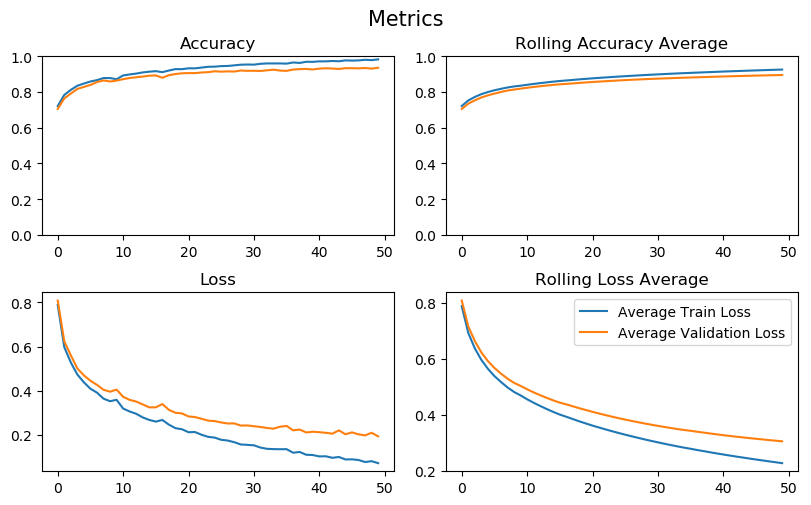

In [50]:
# Plot variables over training and validation - 5e-6 - 100 epochs
mm.plot_metrics(model_2.accuracy_list, 
                model_2.losses_list, 
                model_2.val_accuracy_list, 
                model_2.val_losses_list, 
                save_title='wo_kCV_metrics')

In [51]:
# Get train metrics report
report = classification_report(np.argmax(model_2.y_train, axis=1), 
                                  model_2.preds_list, 
                                  target_names=class_to_num, 
                                  output_dict=True)
my_df = pd.DataFrame.from_dict(report).T.round(2)
my_df

,f1-score,precision,recall,support
Myself,0.99,0.99,0.99,5469.00
Sister,0.98,0.98,0.98,5772.00
Mother,0.98,0.98,0.98,5318.00
Father,0.98,0.99,0.98,2071.00
accuracy,0.98,0.98,0.98,0.98
macro avg,0.98,0.98,0.98,18630.00
weighted avg,0.98,0.98,0.98,18630.00


In [52]:
print(my_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  f1-score &  precision &  recall &   support \\
\midrule
Myself       &      0.99 &       0.99 &    0.99 &   5469.00 \\
Sister       &      0.98 &       0.98 &    0.98 &   5772.00 \\
Mother       &      0.98 &       0.98 &    0.98 &   5318.00 \\
Father       &      0.98 &       0.99 &    0.98 &   2071.00 \\
accuracy     &      0.98 &       0.98 &    0.98 &      0.98 \\
macro avg    &      0.98 &       0.98 &    0.98 &  18630.00 \\
weighted avg &      0.98 &       0.98 &    0.98 &  18630.00 \\
\bottomrule
\end{tabular}



In [53]:
# Get validation metrics report
report = classification_report(np.argmax(model_2.y_val, axis=1), 
                                  model_2.preds_list_val, 
                                  target_names=class_to_num, 
                                  output_dict=True)
my_df = pd.DataFrame.from_dict(report).T.round(2)
my_df

,f1-score,precision,recall,support
Myself,0.94,0.95,0.92,659.00
Sister,0.93,0.92,0.93,600.00
Mother,0.93,0.92,0.94,560.00
Father,0.97,0.96,0.97,251.00
accuracy,0.94,0.94,0.94,0.94
macro avg,0.94,0.94,0.94,2070.00
weighted avg,0.94,0.94,0.94,2070.00


In [54]:
print(my_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  f1-score &  precision &  recall &  support \\
\midrule
Myself       &      0.94 &       0.95 &    0.92 &   659.00 \\
Sister       &      0.93 &       0.92 &    0.93 &   600.00 \\
Mother       &      0.93 &       0.92 &    0.94 &   560.00 \\
Father       &      0.97 &       0.96 &    0.97 &   251.00 \\
accuracy     &      0.94 &       0.94 &    0.94 &     0.94 \\
macro avg    &      0.94 &       0.94 &    0.94 &  2070.00 \\
weighted avg &      0.94 &       0.94 &    0.94 &  2070.00 \\
\bottomrule
\end{tabular}



In [55]:
# Get test metrics report
report = classification_report(np.argmax(model_2.y_test, axis=1), 
                                  model_2.preds_list_test, 
                                  target_names=class_to_num, 
                                  output_dict=True)
my_df = pd.DataFrame.from_dict(report).T.round(2)
my_df

,f1-score,precision,recall,support
Myself,0.96,0.95,0.96,334.00
Sister,0.95,0.96,0.94,322.00
Mother,0.94,0.94,0.95,314.00
Father,0.95,0.96,0.95,122.00
accuracy,0.95,0.95,0.95,0.95
macro avg,0.95,0.95,0.95,1092.00
weighted avg,0.95,0.95,0.95,1092.00


In [56]:
print(my_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  f1-score &  precision &  recall &  support \\
\midrule
Myself       &      0.96 &       0.95 &    0.96 &   334.00 \\
Sister       &      0.95 &       0.96 &    0.94 &   322.00 \\
Mother       &      0.94 &       0.94 &    0.95 &   314.00 \\
Father       &      0.95 &       0.96 &    0.95 &   122.00 \\
accuracy     &      0.95 &       0.95 &    0.95 &     0.95 \\
macro avg    &      0.95 &       0.95 &    0.95 &  1092.00 \\
weighted avg &      0.95 &       0.95 &    0.95 &  1092.00 \\
\bottomrule
\end{tabular}



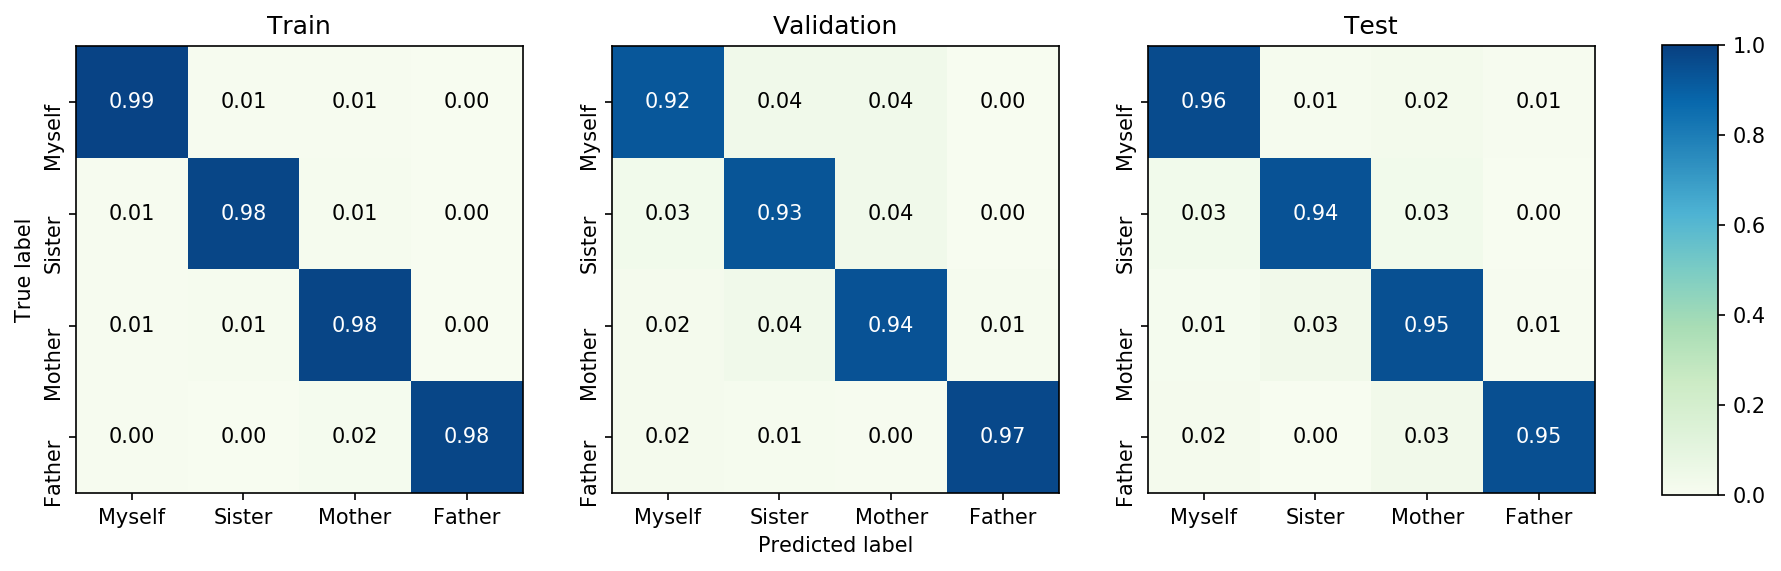

In [57]:
plot_all_confusion_matrices(np.argmax(model_2.y_train, axis=1), model_2.preds_list, 
                            np.argmax(model_2.y_val, axis=1),   model_2.preds_list_val,
                            np.argmax(model_2.y_test, axis=1),  model_2.preds_list_test,
                            np.array(num_to_class), 'CombinedCM_wo_kCV', normalize=True)

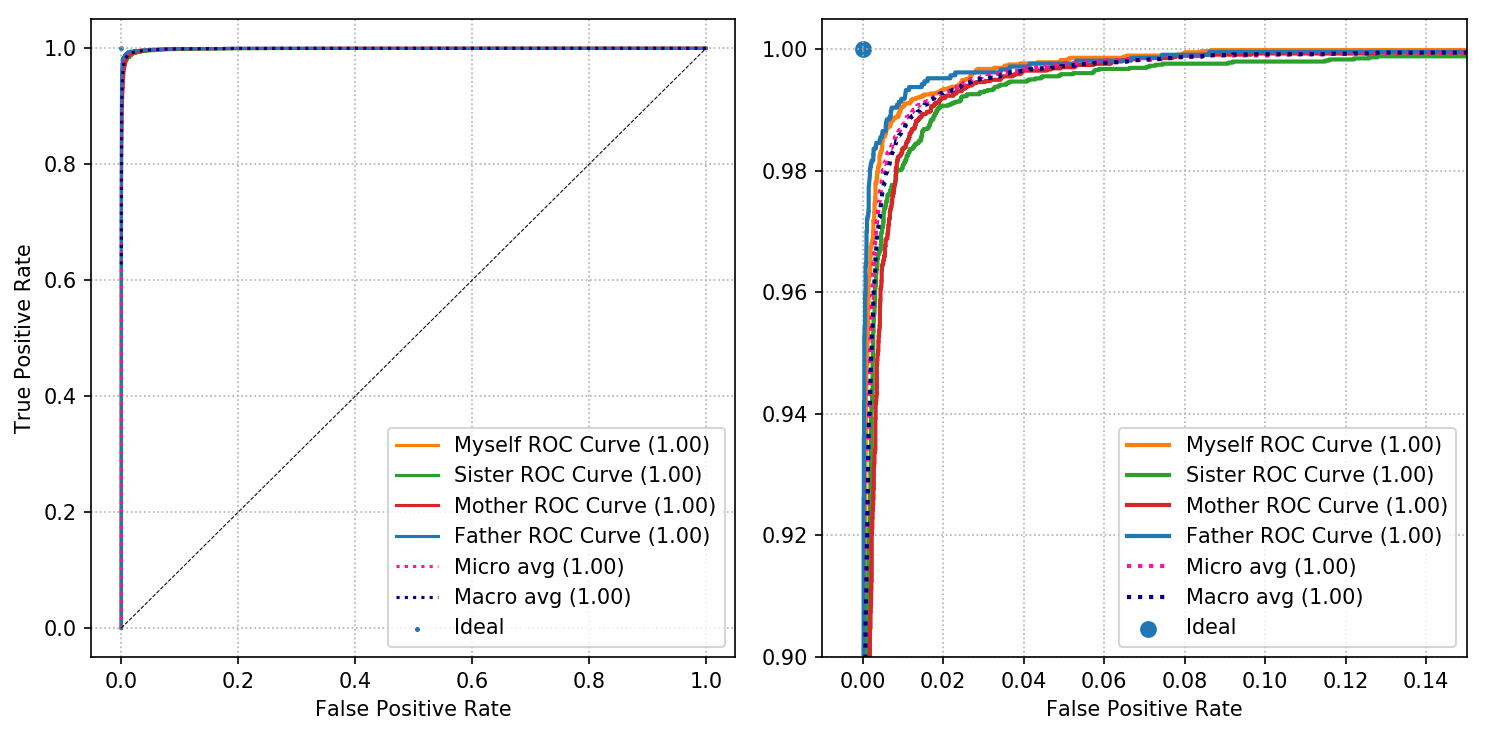

In [58]:
# Train ROC/AUC
fpr, tpr, thresholds, roc_auc = make_fpr_tpr_auc_dicts(model_2.y_train, model_2.probs_list)
plot_roc_auc_curves(fpr, tpr, roc_auc, 'TrainROC_wo_kCV', xlim=(-0.01, 0.15), ylim=(0.90, 1.005))

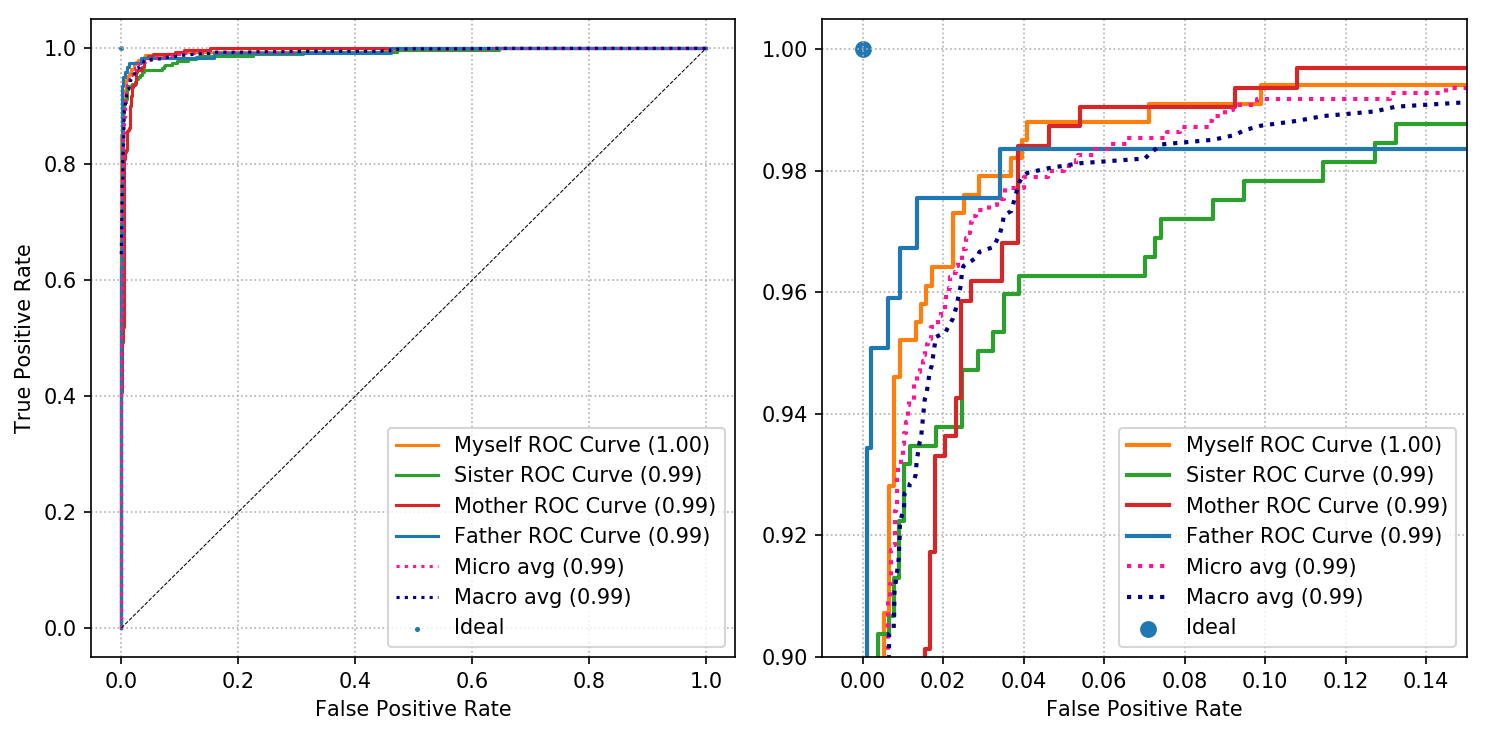

In [59]:
# Test ROC/AUC
fpr, tpr, thresholds, roc_auc = make_fpr_tpr_auc_dicts(model_2.y_test, model_2.probs_list_test)
plot_roc_auc_curves(fpr, tpr, roc_auc, 'TestROC_wo_kCV', xlim=(-0.01, 0.15), ylim=(0.90, 1.005))

# Compare Models

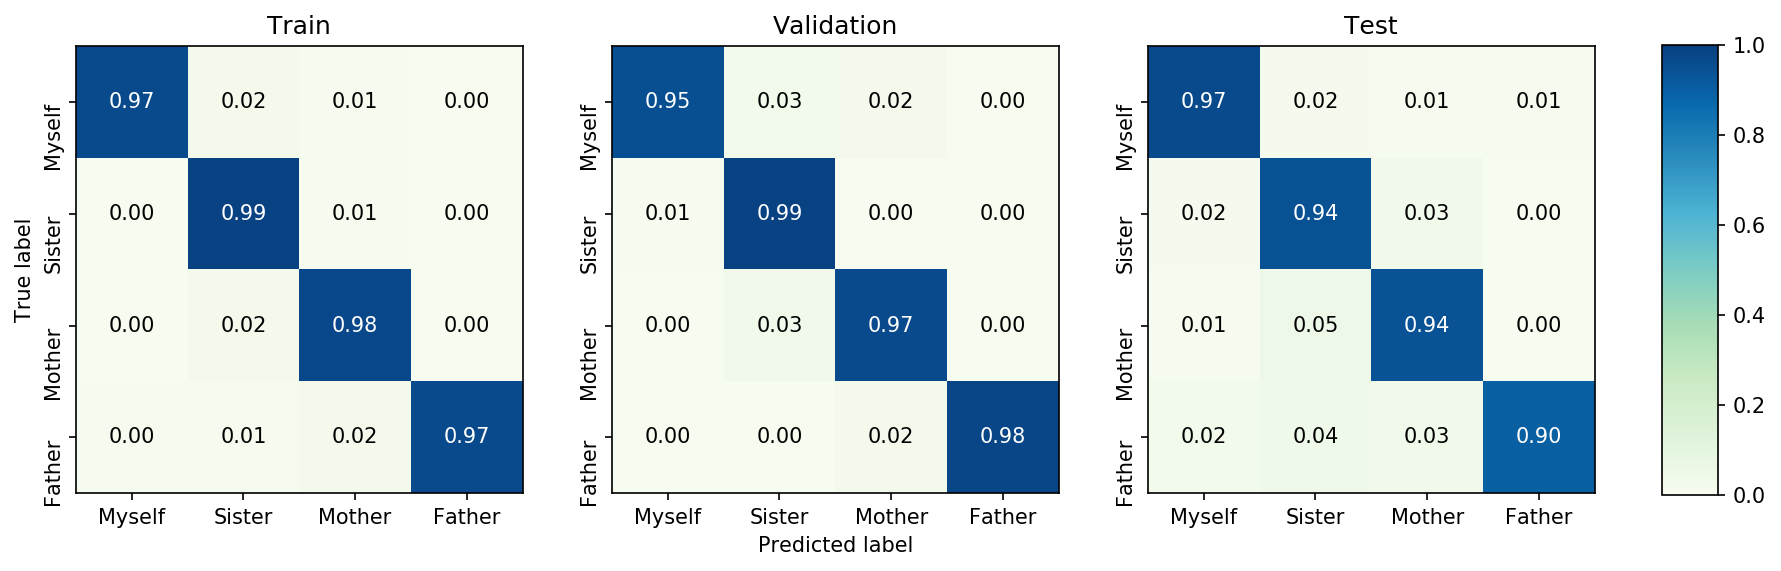

In [60]:
# With k-cross val
plot_all_confusion_matrices(np.argmax(model.y_train, axis=1), model.preds_list, 
                            np.argmax(model.y_val, axis=1),   model.preds_list_val,
                            np.argmax(model.y_test, axis=1),  model.preds_list_test,
                            np.array(num_to_class), 'CombinedCM_w_kCV', normalize=True)

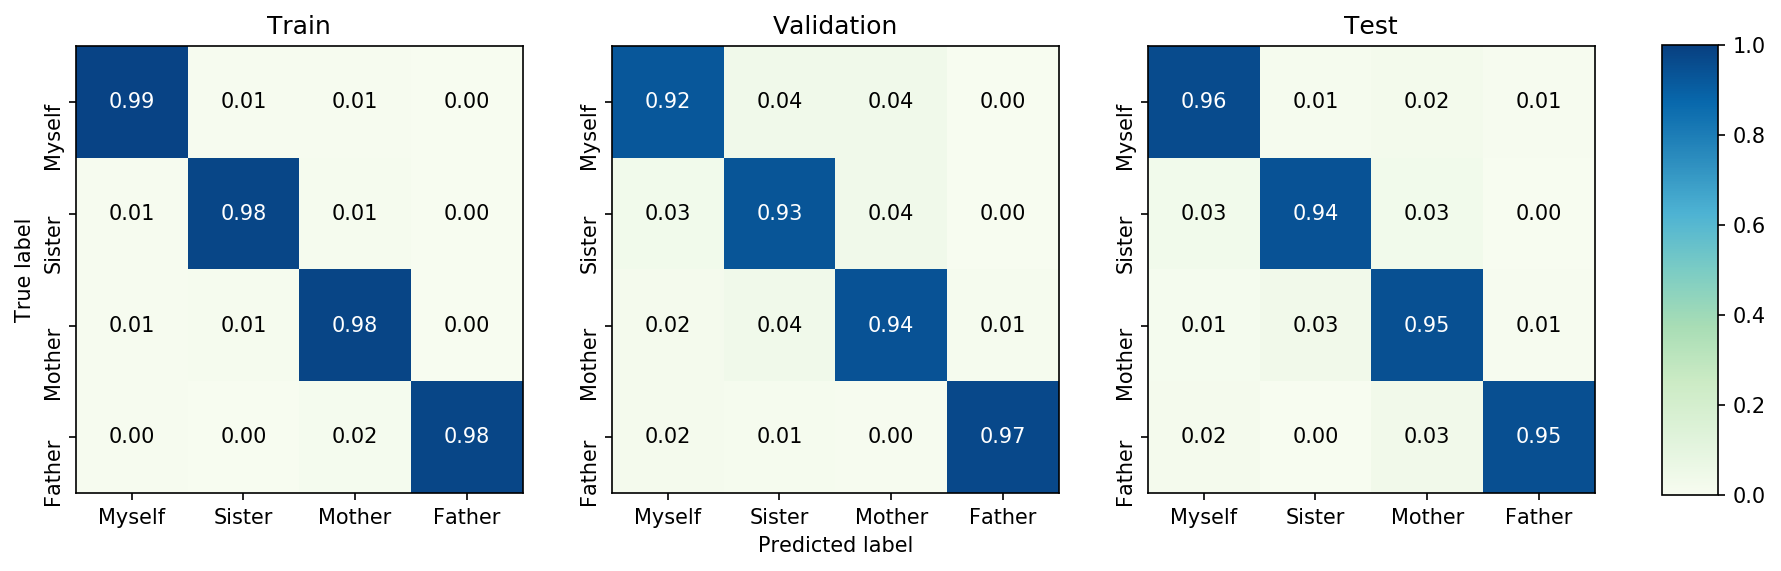

In [61]:
# W/o k-cross val
plot_all_confusion_matrices(np.argmax(model_2.y_train, axis=1), model_2.preds_list, 
                            np.argmax(model_2.y_val, axis=1),   model_2.preds_list_val,
                            np.argmax(model_2.y_test, axis=1),  model_2.preds_list_test,
                            np.array(num_to_class), 'CombinedCM_wo_kCV', normalize=True)

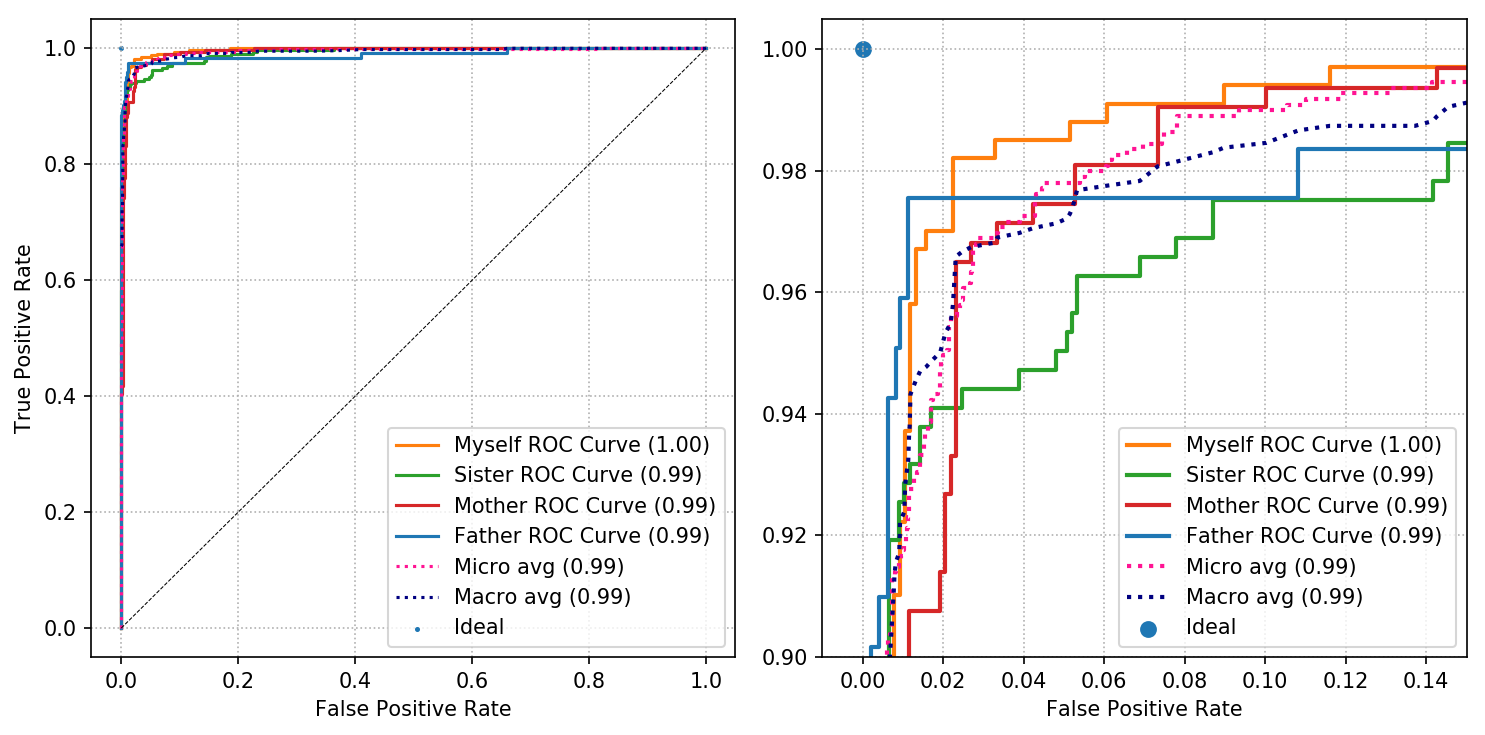

In [62]:
# Test ROC/AUC w/k-cross val
fpr, tpr, thresholds, roc_auc = make_fpr_tpr_auc_dicts(model.y_test, model.probs_list_test)
plot_roc_auc_curves(fpr, tpr, roc_auc, 'TestROC_w_kCV', xlim=(-0.01, 0.15), ylim=(0.90, 1.005))

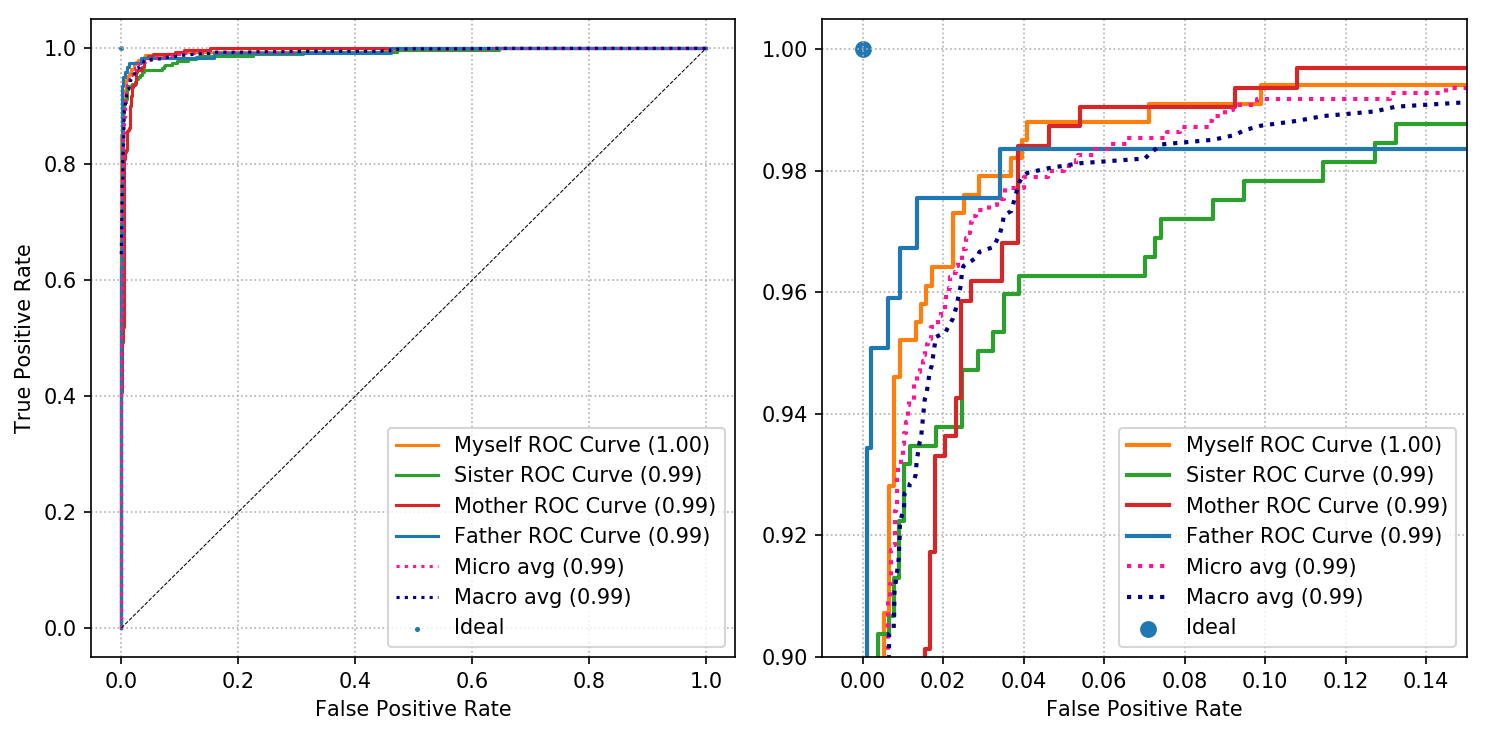

In [63]:
# Test ROC/AUC w/o k-cross val
fpr_2, tpr_2, thresholds_2, roc_auc_2 = make_fpr_tpr_auc_dicts(model_2.y_test, model_2.probs_list_test)
plot_roc_auc_curves(fpr_2, tpr_2, roc_auc_2, 'TestROC_wo_kCV', xlim=(-0.01, 0.15), ylim=(0.90, 1.005))

In [64]:
def compare_roc_auc_curves(fpr, tpr, roc_auc, fpr_2, tpr_2, roc_auc_2, xlim=(-0.0025, 0.03), ylim=(0.99, 1.001)):
    '''Plot ROC AUC Curves'''
    fig, axes = plt.subplots(nrows=3, ncols=2, dpi=150, figsize=(8,8))
    
    lw = 2
    #axes[0][0].set_xlabel('False Positive Rate')
    #axes[1][0].set_xlabel('False Positive Rate')
    #axes[2][0].set_xlabel('False Positive Rate')
    #axes[0].set_ylabel('True Positive Rate')
    
    c=0
    for i in range(len(axes)-1):
        for j in range(len(axes[0])):
            axes[i][j].set_title(num_to_class[c])
            axes[i][j].plot(fpr[c], tpr[c], lw=1, label='{0} ({1:0.2f})' ''.format('w/k-CV', roc_auc[c]))
            axes[i][j].plot(fpr_2[c], tpr_2[c], lw=1, label='{0} ({1:0.2f})' ''.format('w/o k-CV', roc_auc[c]))
            c += 1
    
    axes[2][0].set_title('Micro avg')
    #axes[0].plot(fpr['micro'], tpr['micro'], label='Micro avg (%0.2f)' % roc_auc['micro'], linestyle=':', color='deeppink')
    axes[2][0].plot(fpr['micro'], tpr['micro'], label='w/k-CV (%0.3f)' % roc_auc['micro'], linestyle=':')
    axes[2][0].plot(fpr_2['micro'], tpr_2['micro'], label='w/o k-CV (%0.3f)' % roc_auc_2['micro'], linestyle=':')
    #axes[0].plot([0, 1], [0, 1], color='k', linestyle='--', lw=0.5)
    
    axes[2][1].set_title('Macro avg')
    #axes[1].plot(fpr['micro'], tpr['micro'], lw=lw, label='Micro avg (%0.2f)' % roc_auc['micro'], linestyle=':', color='deeppink')
    axes[2][1].plot(fpr['macro'], tpr['macro'], label='w/k-CV (%0.3f)' % roc_auc['macro'], linestyle=':')
    axes[2][1].plot(fpr_2['macro'], tpr_2['macro'], label='w/o k-CV (%0.3f)' % roc_auc_2['macro'], linestyle=':')
    #axes[1].plot([0, 1], [0, 1], color='k', linestyle='--', lw=0.5)
    
    for i in range(len(axes)):
        for j in range(len(axes[0])):
            axes[i][j].set_xlim(xlim)
            axes[i][j].set_ylim(ylim)
            axes[i][j].grid(True, linestyle='dotted', alpha=1)
            axes[i][j].grid(True, linestyle='dotted', alpha=1)
            axes[i][j].legend(loc=4)
            axes[i][j].legend(loc=4)
            axes[i][j].scatter(0,1, s=25)
    
    plt.legend(loc="lower right")
    fig.tight_layout() 
    fig.savefig('CombinedROCPerClass.pdf', bbox_inches='tight', format='pdf', dpi=200)
    plt.show()

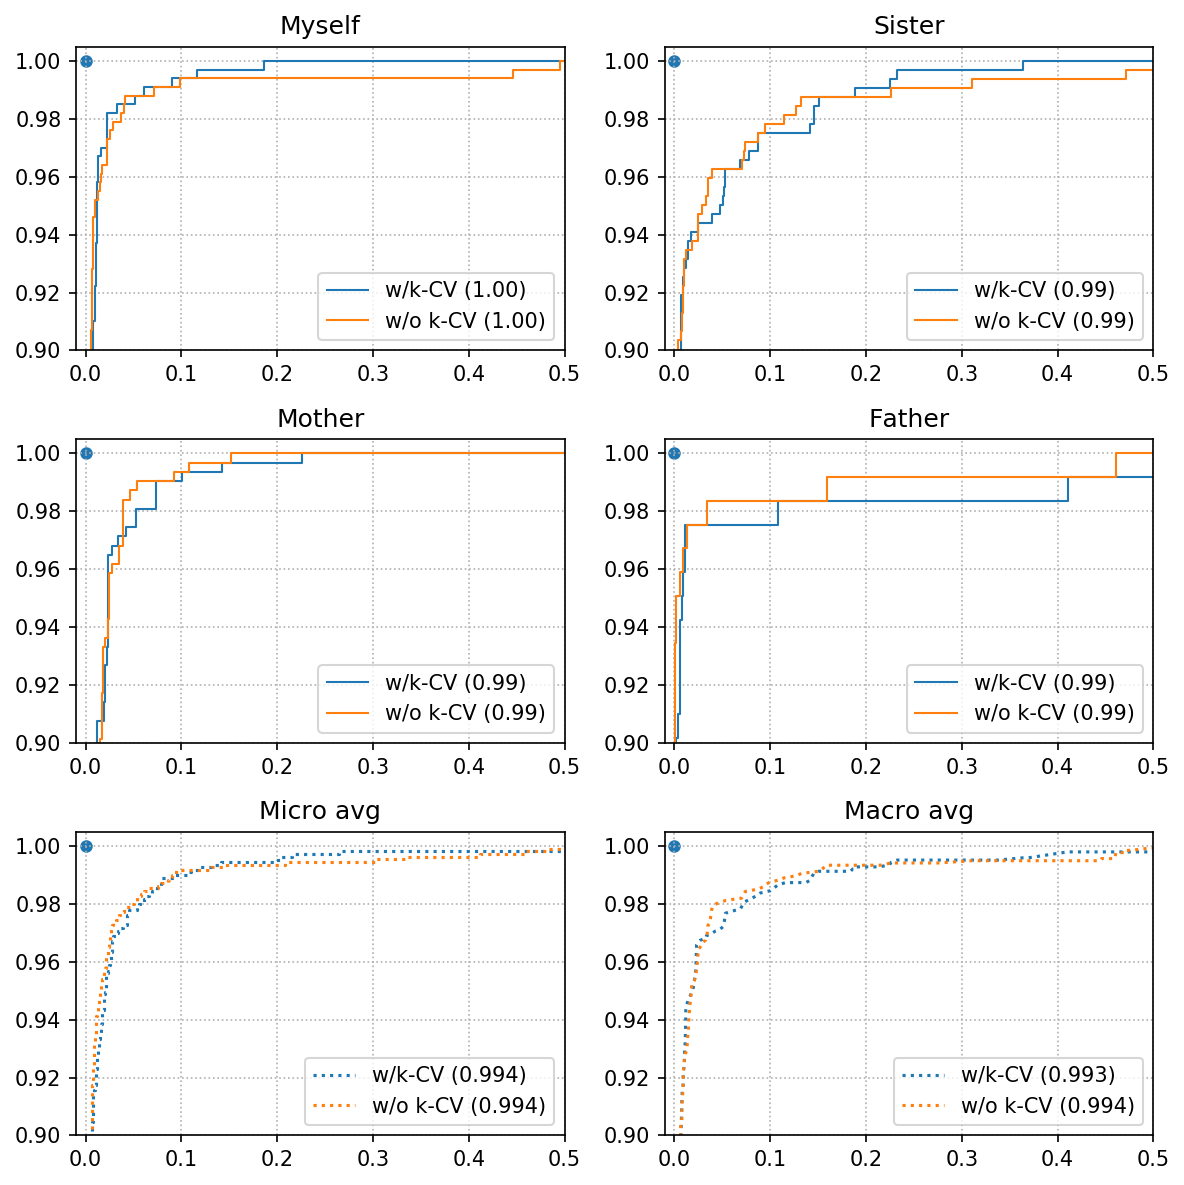

In [65]:
compare_roc_auc_curves(fpr, tpr, roc_auc, fpr_2, tpr_2, roc_auc_2, xlim=(-0.01, 0.5), ylim=(0.90, 1.005))

In [66]:
#%%capture --no-display

#false_positives_idx = get_false_classifications(y_real, all_preds)
#plot_results(x_test[false_positives_idx], 
#             y_real[false_positives_idx], 
#             all_preds[false_positives_idx], 
#             probs_list[false_positives_idx], 
#             dynamic=False)

In [67]:
# Plot random pics
# a,b,c,d = shuffle(x_test[:120], y_real, all_preds, probs_list, random_state=0)
# plot_results(a, b, c, d, sleep_time=3.0)

In [68]:
# Plot random pics
# %%capture --no-display
# chosen_rand_pics = np.array([dad_pics[i] for i in np.random.randint(0, len(dad_pics), 5)])
# k = sess.run(model.preds, feed_dict={model.im:chosen_rand_pics})
# plot_results(chosen_rand_pics, np.array([3]*len(chosen_rand_pics)), np.argmax(k, axis=1), k, dynamic=False)

In [69]:
#plot_confusion_matrix(y_real, all_preds, np.array(num_to_class), normalize=True)

In [70]:
# Precision - Positive predictive value = true_pos / (true_pos + false_pos)
# Recall - Positive rate = true_pos / (true_pos + false_neg)
# F1: Weighted harmonic mean of precision and recall = 2 * (precision * recall) / (precision + recall)
# Support: Number of occurrences of each class in y_true
# Macro avg - averaging the unweighted mean per label
# Weighted avg - averaging the support-weighted mean per label
        
#print(classification_report(y_real, all_preds, target_names=num_to_class))

In [71]:
# Close session
model_2.sess.close()